# The Unscented Transform
First, we will study the unscented transform by itself, to see how it works and apply it to a Kalman Filter.

The unscented transform is used when the linearization by Taylor expansion from the EKF doesn't perform optimally. 

Instead of approximating a function g by a Taylor series expansion, the unscented transform extracts sigma points from the Gaussian and passes these through g. Each sigma point has a weight, and the Gaussian is computed from the weighted points

In [1]:
!pip install celluloid

In [2]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from celluloid import Camera
from IPython.display import HTML
import numpy as np
import os
import math
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)
from scipy.stats import multivariate_normal
from scipy import stats

%matplotlib inline


First we compute the initial Gaussian ditribution, with given mean and covariance as follows

In [3]:
# mean and vector for covariance matrix
sigma = 0.1*np.identity(2)
mu = np.array([[1],[2]])
n = mu.shape[0]

Let's plot it! The colors correspond with the density of points in the surrounding area

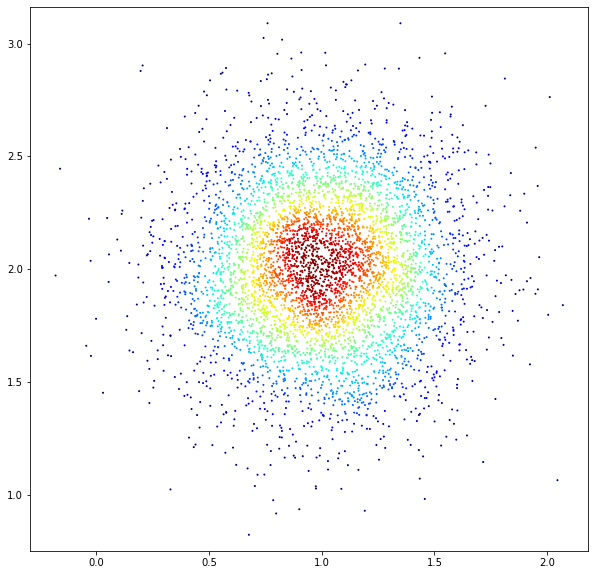

In [4]:
xinput, yinput = np.random.multivariate_normal(mu.flatten(), sigma, 5000).T
kdeinput = stats.gaussian_kde([xinput,yinput])
zinput = kdeinput([xinput,yinput])
ccinput = cm.jet((zinput-zinput.min())/(zinput.max()-zinput.min()))
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.scatter(xinput,yinput,marker='o',facecolors=ccinput,s=1)
ax.set_aspect('equal','datalim')
plt.show()

The next step is extracting the sigma points. They are located at the mean and symmetrically along the main axes of the covariance (two per dimension). In the literature, different sets of sigma points have been proposed. In general, $n+1$ sigma points are necessary and sufficient to define a discrete distribution having a given mean and covariance in $n$ dimensions.

 Here, for a n-dimensional Gaussian with mean $\mu$ and covariance $\scriptstyle\sum$ , the resulting 2n+1 sigma points $X^{[i]}$ are chosen symmetrically according to the following rule:
 \begin{equation}
 X^{[0]} = \mu 
 \end{equation}
  \begin{equation}
 X^{[i]} = \mu + (\sqrt{(n+\lambda)\scriptstyle{\sum}})_i \quad \text{ for } i = 1,...,n
 \end{equation}
  \begin{equation}
 X^{[i]} = \mu - (\sqrt{(n+\lambda)\scriptstyle{\sum}})_{i-n} \quad \text{ for } i = n+1,...,2n
 \end{equation}

 Where $\lambda = \alpha^2(n+k)-n$ , with $\alpha$ and $k$ being scaling parameters that determine how far the sigma points are spread from the mean.
This method is computationally efficient and, because the points form a symmetric distribution, it captures the third central moment (the skew).

EKF via the Taylor expansion, computes the derivative and thus gives us the first moment of the distribution, that is, the mean.
The Unscented transform is then more robust, because we take into account the first moment (the mean), the second moment (the standard deviation), and the third moment (the skew).

Points that are close together will sample local effects, and thus probably work better for very nonlinear problems. Points that are far apart, or far off the axis of the ellipse will sample non-local effects and non Gaussian behavior. However, by varying the weights used for each point we can mitigate this. If the points are far from the mean but weighted very slightly we will incorporate some of the knowledge about the distribution without allowing the nonlinearity of the problem to create a bad estimate.

So first, compute $\lambda$:

In [5]:
alpha = 0.9
beta = 2
kappa = 1
lmbda = alpha**2*(n+kappa)-n

Now, compute the sigma points.
Each sigma point  $X^{[i]}$ has two weights associated, one for the mean ($w^{[i]}_m$), and the other used when recovering the covariance ($w^{[i]}_c$)

In [6]:
def compute_sigma_points( mu, sigma, lmbda, alpha, beta):
  n = mu.shape[0]
  # initialize sigma points
  sigma_points = np.zeros((n,2*n+1))+mu # matrix product this way is element-wise
  # compute square root matrix
  sqrm = np.sqrt((n+lmbda)*sigma)
  for i in range (1,n+1):
    sigma_points[:,i]+= sqrm[:,i-1]
  for i in range(n+1,2*n+1):
    sigma_points[:,i]-= sqrm[:,i-n-1]
  
  # compute the weights
  wc = np.ones((1,2*n+1))*lmbda/(n+lmbda)
  wc[0][1:] *= (1/(2*lmbda))
  wm = wc.copy()
  wc[0][0] += 1-alpha**2+beta

  return sigma_points,wm,wc




In [7]:
sigma_points,wm,wc = compute_sigma_points( mu, sigma, lmbda, alpha, beta)
sigma_points

array([[1.       , 1.4929503, 1.       , 0.5070497, 1.       ],
       [2.       , 2.       , 2.4929503, 2.       , 1.5070497]])

Let's now plot the gaussian again, but with the sigma points

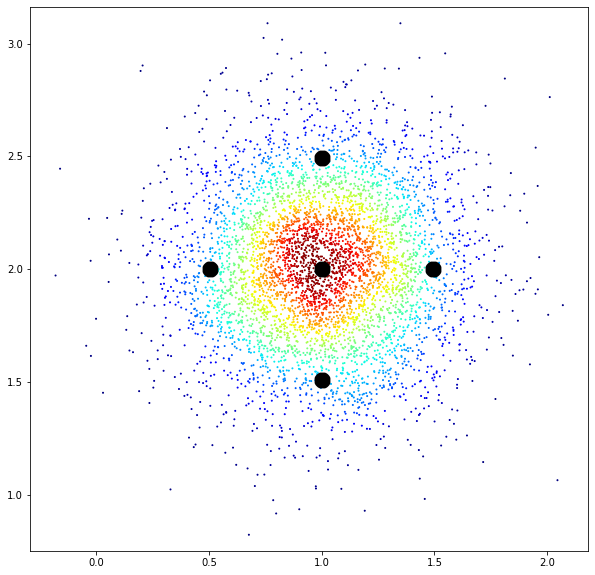

In [8]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
ax.scatter(xinput,yinput,marker='o',facecolors=ccinput,s=1)
#Plot sigma
ax.scatter(sigma_points[0][:],sigma_points[1][:],c = 'black', marker = 'X',linewidths = 10)


ax.set_aspect('equal','datalim')
plt.show()

# A simple example: shifting the Gaussian

Let's define the function we're applying to the points

In [9]:
def nonlinearf(x,y):
    return x+1,y+2

And pass the points through this non linear function

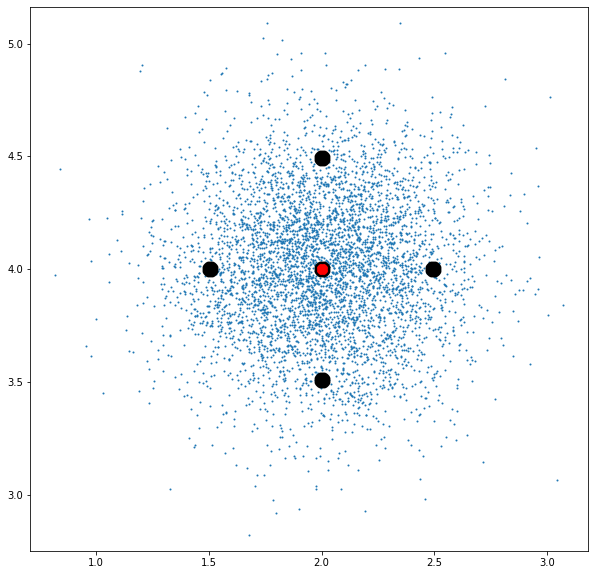

In [10]:
#  Pass the Gaussian points through the nonlinear function
xnonlinear,ynonlinear = nonlinearf(xinput,yinput)
# Pass the sigma points through that same function
sigmaxnonlinear,sigmaynonlinear = nonlinearf(sigma_points[0][:],sigma_points[1][:])



fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
# Plot nonlinear function
ax.scatter(xnonlinear,ynonlinear,marker='o',s=1)
#Plot sigma
ax.scatter(sigmaxnonlinear,sigmaynonlinear,c = 'black', marker = 'X',linewidths = 10)
ax.scatter(sigmaxnonlinear[0],sigmaynonlinear[0],c = 'red', marker = 'X',linewidths = 5)

ax.set_aspect('equal','datalim')
plt.show()

Let's plot the input and the new distribution together:

/home/olaya/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


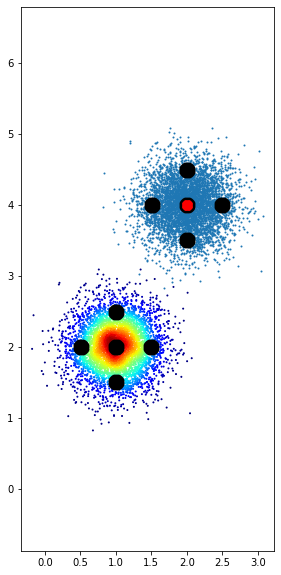

In [11]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(1,2,1)
ax1.scatter(xinput,yinput,marker='o',facecolors=ccinput,s=1)
#Plot gaussian
ax1.scatter(sigma_points[0][:],sigma_points[1][:],c = 'black', marker = 'X',linewidths = 10)


ax1.set_aspect('equal','datalim')


ax2 = plt.subplot(1,2,1)


# Plot nonlinear function
ax2.scatter(xnonlinear,ynonlinear,marker='o',s=1)
#Plot sigma
ax2.scatter(sigmaxnonlinear,sigmaynonlinear,c = 'black', marker = 'X',linewidths = 10)
ax2.scatter(sigmaxnonlinear[0],sigmaynonlinear[0],c = 'red', marker = 'X',linewidths = 5)

ax2.set_aspect('equal','datalim')
plt.show()

The sigma points pass through the nonlinear function, and thus we can see how the shape of the gaussian is changing.
\begin{equation}
Y^{[i]} = g(X^{[i]})
\end{equation}

The mean and covariance are estimated from the mapped sigma points $Y^{[i]}$ according to:
\begin{equation}
\mu' = \sum_{i=0}^{2n}Y^{[i]}w^{[i]}_m 
\end{equation}
\begin{equation}
\sum' = \sum_{i=0}^{2n}(Y^{[i]}-\mu')(Y^{[i]}-\mu')^T
\end{equation}

In [12]:
def recover_gaussian(sigmas,wm,wc):
  n = sigmas.shape[0]
  # initialize mean and covariance
  #mu = np.zeros((n,1))
  newsigma = np.zeros((n,n))

  # Compute mean and covar of the resulting distribution given the transformed
  # sigma points and corresponding weights
  mu = np.sum(sigmas*wm, axis = 1,keepdims = True)

  for i in range(2*n+1):
    newsigma += wc[i]*np.matmul(sigmas[:,i,np.newaxis]-mu,(sigmas[:,i,np.newaxis]-mu).T)

  return mu,newsigma



In [13]:
muoutput,sigmaoutput = recover_gaussian(np.array([sigmaxnonlinear,sigmaynonlinear]),wm.flatten(),wc.flatten())

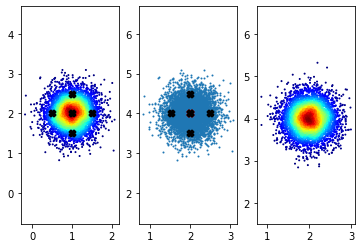

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)



ax1.scatter(xinput,yinput,marker='o',facecolors=ccinput,s=1)
#Plot gaussian
ax1.scatter(sigma_points[0][:],sigma_points[1][:],c = 'black', marker = 'X',linewidths = 2)


ax1.set_aspect('equal','datalim')





# Plot nonlinear function
ax2.scatter(xnonlinear,ynonlinear,marker='o',s=1)
#Plot sigma
ax2.scatter(sigmaxnonlinear,sigmaynonlinear,c = 'black', marker = 'X',linewidths = 2)
ax2.scatter(sigmaxnonlinear[0],sigmaynonlinear[0],c = 'red', marker = 'X',linewidths = 2)

ax2.set_aspect('equal','datalim')


# Plot new gaussian


xoutput, youtput = np.random.multivariate_normal(muoutput.flatten(), sigmaoutput, 5000).T
kdeoutput = stats.gaussian_kde([xoutput, youtput])
zoutput = kdeoutput([xoutput, youtput])
ccoutput = cm.jet((zoutput-zoutput.min())/(zoutput.max()-zoutput.min()))

ax3.scatter(xoutput,youtput,marker='o',facecolors=ccoutput,s=1)
ax2.scatter(muoutput[0],muoutput[1],c = 'black', marker = 'X',linewidths = 2)

ax3.set_aspect('equal','datalim')
plt.show()


plt.show()



# Putting it all together

Let's define a class with the different parameters defined by the Unscented filter, so we can see how the results change by varying these parameters!

In [15]:
class Unscented(object):
  def __init__(self, sigma, mu, ftype):

    # Unscented parameters 
    self.alphav = [0.1, 0.3, 0.5, 0.9]
    self.betav = [1,2,3,4]
    self.kappav = [0.1,0.3,0.5,0.9]
    self.ftype = ftype

  def animated_loop(self):

    #Generate the figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))

    camera = Camera(fig)
    
    # Generate STATIC values
    xinput, yinput = np.random.multivariate_normal(mu.flatten(), sigma, 5000).T
    #  Pass the Gaussian points through the nonlinear function
    xnonlinear,ynonlinear = self.nonlinearf(xinput,yinput,self.ftype)

    for alpha in self.alphav:
      for beta in self.betav:
        for kappa in self.kappav:

          # obtain lambda from the rest of the parameters
          lmbda = alpha**2*(n+kappa)-n

          ax2.text(0.5,0.9,'alpha ='+str(alpha)+'\n'+ 'beta ='+str(beta)+'\n'+ 'kappa ='+str(kappa),horizontalalignment='center',verticalalignment='top', transform=ax2.transAxes)

          # Compute sigma points of the distribution
          sigma_points,wm,wc = self.compute_sigma_points( mu, sigma, lmbda, alpha, beta)

          # Pass them through the nonlinear function
          sigmaxnonlinear,sigmaynonlinear = self.nonlinearf(sigma_points[0][:],
                                                            sigma_points[1][:],self.ftype)

          # Recover the new gaussian
          muoutput,sigmaoutput = self.recover_gaussian(np.array([sigmaxnonlinear,
                                                                sigmaynonlinear]),
                                                      wm.flatten(),wc.flatten())

          #plot
          fig = self.plot_transform(fig, ax1, ax2, ax3, xinput,yinput,
                                    xnonlinear,ynonlinear, sigmaxnonlinear,
                                    sigmaynonlinear,muoutput,sigmaoutput,self.ftype)
          camera.snap()
    animation = camera.animate()
    return HTML(animation.to_html5_video())

  def compute_sigma_points( self, mu, sigma, lmbda, alpha, beta):
    n = mu.shape[0]
    # initialize sigma points
    sigma_points = np.zeros((n,2*n+1))+mu # matrix product this way is element-wise
    # compute square root matrix
    sqrm = np.sqrt((n+lmbda)*sigma)
    for i in range (1,n+1):
      sigma_points[:,i]+= sqrm[:,i-1]
    for i in range(n+1,2*n+1):
      sigma_points[:,i]-= sqrm[:,i-n-1]
    
    # compute the weights
    wc = np.ones((1,2*n+1))*lmbda/(n+lmbda)
    wc[0][1:] *= (1/(2*lmbda))
    wm = wc.copy()
    wc[0][0] += 1-alpha**2+beta

    return sigma_points,wm,wc

  # nonlinear function to apply to the sigma points
  def nonlinearf(self, x,y,ftype):
    if (ftype == 'shift'):
      return x+1,y+2
    if (ftype == 'trig'):
      return np.cos(x),np.sin(x)
    if (ftype == 'second'):
      return x**2,y**2
    if (ftype == 'third'):
      return x**3,y**3
    if (ftype == 'fourth'):
      return x**4,y**4
    if (ftype == 'exp'):
      return np.exp(x),y
    if (ftype == 'mix1'):
      return (np.cos(4*(x/2 + 0.7))) - 1.3*x,(np.cos(4*(y/2 + 0.7))) - 1.3*y
    

  def recover_gaussian(self,sigmas,wm,wc):
    n = sigmas.shape[0]
    # initialize mean and covariance
    #mu = np.zeros((n,1))
    newsigma = np.zeros((n,n))

    # Compute mean and covar of the resulting distribution given the transformed
    # sigma points and corresponding weights
    mu = np.sum(sigmas*wm, axis = 1,keepdims = True)

    for i in range(2*n+1):
      newsigma += wc[i]*np.matmul(sigmas[:,i,np.newaxis]-mu,(sigmas[:,i,np.newaxis]-mu).T)

    return mu,newsigma

  def plot_transform(self,fig, ax1,ax2,ax3, xinput, yinput, 
                     xnonlinear,ynonlinear, sigmaxnonlinear, 
                     sigmaynonlinear, muoutput, sigmaoutput, ftype):

    # Obtain scatter for Gaussian (input) function
    kdeinput = stats.gaussian_kde([xinput,yinput])
    zinput = kdeinput([xinput,yinput])
    ccinput = cm.jet((zinput-zinput.min())/(zinput.max()-zinput.min()))
    # Obtain axes for Gaussian
    ax1.scatter(xinput,yinput,marker='o',facecolors=ccinput,s=1)
    ax1.scatter(sigma_points[0][:],sigma_points[1][:],c = 'black', marker = 'X',linewidths = 2)
    ax1.set_aspect('equal','datalim')

    # Obtain scatter for nonlinear function
    # and obtain the axes
    ax2.scatter(xnonlinear,ynonlinear,c = 'blue', marker='o',s=1)
    ax2.scatter(sigmaxnonlinear,sigmaynonlinear,c = 'black', marker = 'X',linewidths = 2)
    ax2.scatter(sigmaxnonlinear[0],sigmaynonlinear[0],c = 'red', marker = 'X',linewidths = 2)
    ax2.set_aspect('equal','datalim')


    # Plot new gaussian


    xoutput, youtput = np.random.multivariate_normal(muoutput.flatten(), sigmaoutput, 5000).T
    kdeoutput = stats.gaussian_kde([xoutput, youtput])
    zoutput = kdeoutput([xoutput, youtput])
    ccoutput = cm.jet((zoutput-zoutput.min())/(zoutput.max()-zoutput.min()))

    ax3.scatter(xoutput,youtput,marker='o',facecolors=ccoutput,s=1)
    ax3.scatter(muoutput[0],muoutput[1],c = 'black', marker = 'X',linewidths = 2)

    ax3.set_aspect('equal','datalim')

    return fig

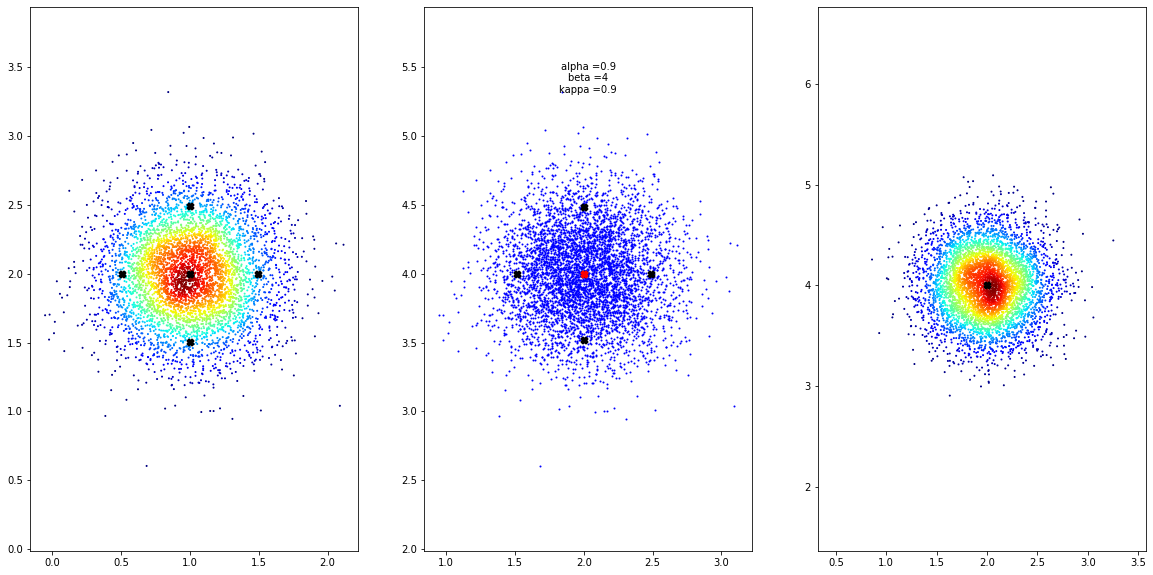

In [16]:
# Gaussian parameters
sigma = 0.1*np.identity(2)
mu = np.array([[1],[2]])
u = Unscented(sigma,mu,'shift')
u.animated_loop()

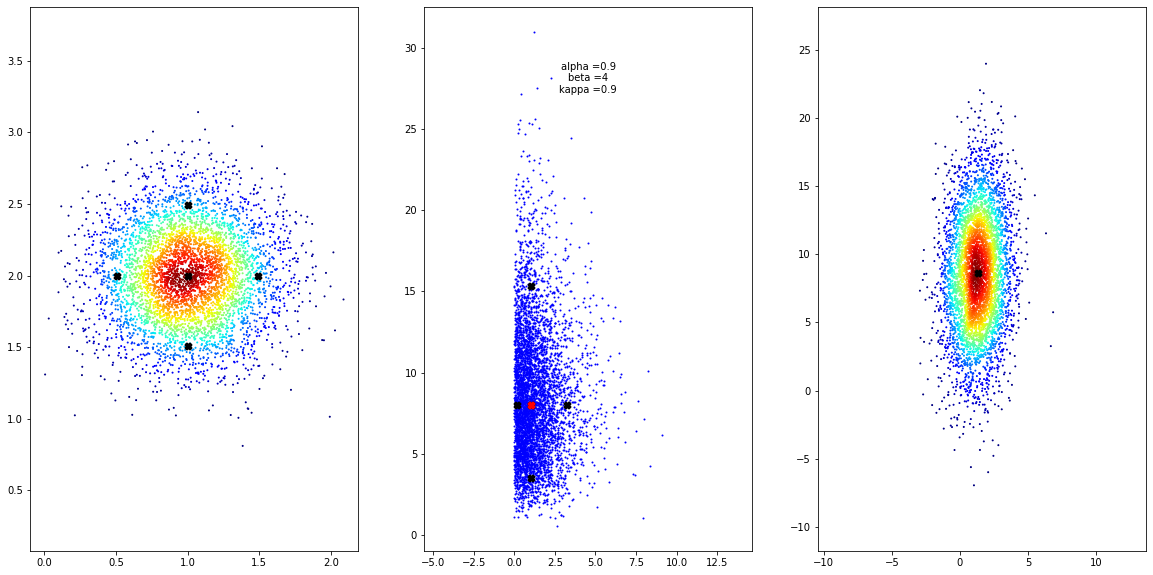

In [17]:
# Gaussian parameters
sigma = 0.1*np.identity(2)
mu = np.array([[1],[2]])
u = Unscented(sigma,mu,'third')
u.animated_loop()

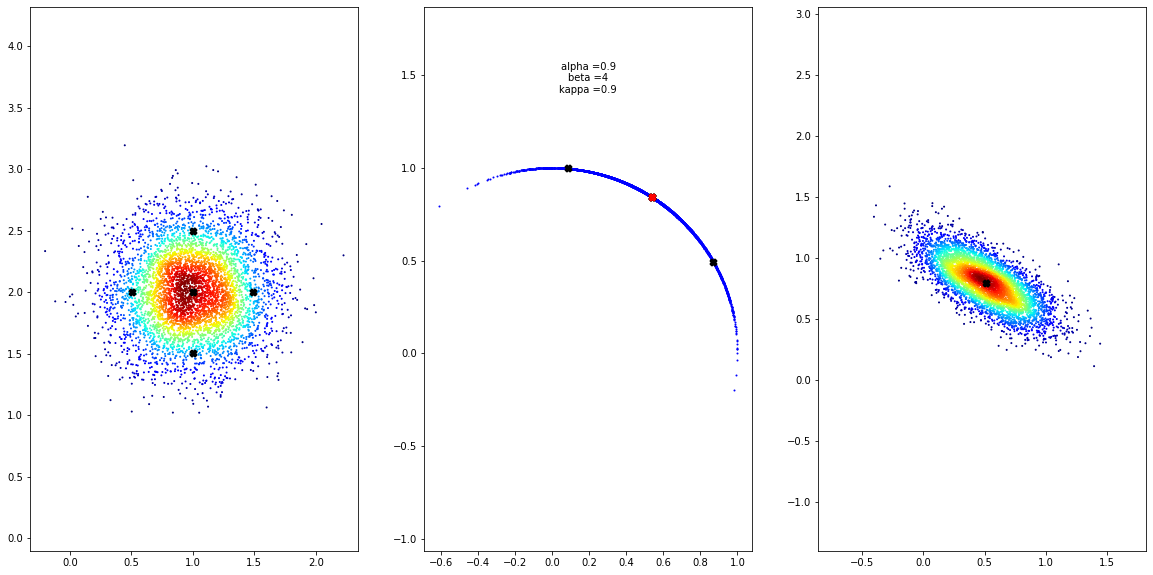

In [18]:
# Gaussian parameters
sigma = 0.1*np.identity(2)
mu = np.array([[1],[2]])
u = Unscented(sigma,mu,'trig')
u.animated_loop()

In [ ]:
# Gaussian parameters
sigma = 0.1*np.identity(2)
mu = np.array([[1],[2]])
u = Unscented(sigma,mu,'mix1')
u.animated_loop()